In [2]:
# Import required libraries here
import cv2                               # OpenCV
import numpy as np                       # numpy
import os
from pupil_apriltags import Detector
import requests
import pickle
import glob   # filename and path management for file I/O

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters or use plt.figure(figsize=[H, W]) before specific plots.
plt.rcParams['figure.figsize'] = [7,5]

In [3]:
def compute_min_max_values(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get the spatial dimensions of the video frames
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize arrays to store min and max values
    min_values = np.full((frame_height, frame_width), np.inf)
    max_values = np.full((frame_height, frame_width), -np.inf)

    # Read frames one by one
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        # Convert frame to grayscale if necessary
        if len(frame.shape) > 2:
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            frame_gray = frame

        # Update min and max values
        min_values = np.minimum(min_values, frame_gray)
        max_values = np.maximum(max_values, frame_gray)

    # Release the video capture object
    cap.release()

    return min_values, max_values


In [4]:

# Example usage:
min_vals, max_vals = compute_min_max_values('data/shadow.mov')

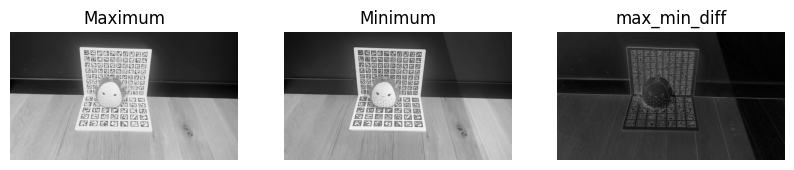

In [5]:
#@title display the results

# Plot the images
plt.figure(figsize=(10, 5))

# Min values image
plt.subplot(1, 3, 1)
plt.imshow(max_vals, cmap='gray')
plt.title('Maximum')
plt.axis('off')

# Min values image
plt.subplot(1, 3, 2)
plt.imshow(min_vals, cmap='gray')
plt.title('Minimum')
plt.axis('off')


# Min values image
plt.subplot(1, 3, 3)
plt.imshow(max_vals-min_vals, cmap='gray')
plt.title('max_min_diff')
plt.axis('off')


plt.show()


In [6]:
cap = cv2.VideoCapture("data/shadow.mov")
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print( total_frames )

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(frame_width)
print(frame_height)

cap.release()

1057
1920
1080


In [7]:
def extract_pixel_values(video_path, pixel:tuple):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    all_values_at_pixel = np.zeros(total_frames)

    # Read frames one by one
    i = 0
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        # Convert frame to grayscale if necessary
        if len(frame.shape) > 2:
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            frame_gray = frame

        all_values_at_pixel[i] = frame_gray[pixel]
        
        i+=1

    # Release the video capture object
    cap.release()

    return all_values_at_pixel


In [8]:
def cut_video(video_path, start_frame, output_path):
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Define codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Adjust codec as needed
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    # Read until the 250th frame
    for _ in range(start_frame):
        ret, _ = cap.read()
        if not ret:
            break

    # Read frames one by one
    i = 0
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        out.write(frame)

    # Release everything
    cap.release()
    out.release()



In [9]:
# cut_video("data/shadow.MOV", int((8/44)*total_frames), "data/shadow_after_placement.mov")

1057
1920
1080


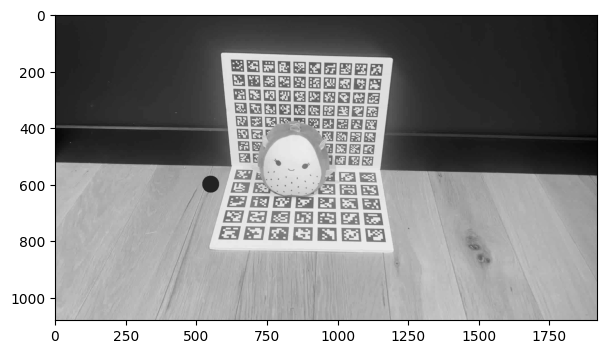

In [10]:
cap = cv2.VideoCapture("data/shadow.mov")
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print( total_frames )

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(frame_width)
print(frame_height)

_,frame = cap.read()

frame = cv2.circle(frame, (550,600), 30, (200,4,56),-1)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)

frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
plt.imshow(frame, cmap="gray")

cap.release()

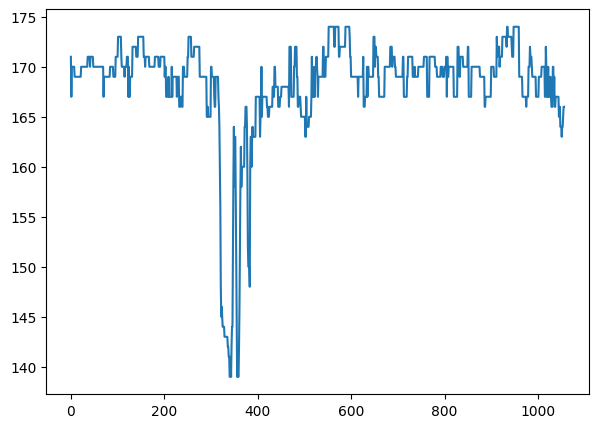

In [11]:
plt.plot(extract_pixel_values("data/shadow.mov", (550,600)[::-1]))

In [12]:
def get_front_edge(video_path, img_min= None, img_max=None):
    if img_min is None or img_max is None:
        img_min, img_max = compute_min_max_values(video_path)
    
    img_shadow_thresh = (img_min+img_max)/2
    print(f"img_shadow_thresh shape: {img_shadow_thresh.shape}")
    front_edge_times = np.zeros_like(img_shadow_thresh, dtype=np.uint64)
    i = 1
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        # Convert frame to grayscale if necessary
        if len(frame.shape) > 2:
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            frame_gray = frame

        front_edge_times = np.where(
            (front_edge_times ==0) & (frame_gray<img_shadow_thresh),
            i,
            front_edge_times)
        print(f"Quack {i}")
        i+=1
    
    cap.release()
    return front_edge_times

In [13]:
video_path = "data/shadow.mov"
# img_min, img_max = compute_min_max_values(video_path)


front_edge_times = get_front_edge(video_path, min_vals, max_vals)

img_shadow_thresh shape: (1080, 1920)
Quack 1
Quack 2
Quack 3
Quack 4
Quack 5
Quack 6
Quack 7
Quack 8
Quack 9
Quack 10
Quack 11
Quack 12
Quack 13
Quack 14
Quack 15
Quack 16
Quack 17
Quack 18
Quack 19
Quack 20
Quack 21
Quack 22
Quack 23
Quack 24
Quack 25
Quack 26
Quack 27
Quack 28
Quack 29
Quack 30
Quack 31
Quack 32
Quack 33
Quack 34
Quack 35
Quack 36
Quack 37
Quack 38
Quack 39
Quack 40
Quack 41
Quack 42
Quack 43
Quack 44
Quack 45
Quack 46
Quack 47
Quack 48
Quack 49
Quack 50
Quack 51
Quack 52
Quack 53
Quack 54
Quack 55
Quack 56
Quack 57
Quack 58
Quack 59
Quack 60
Quack 61
Quack 62
Quack 63
Quack 64
Quack 65
Quack 66
Quack 67
Quack 68
Quack 69
Quack 70
Quack 71
Quack 72
Quack 73
Quack 74
Quack 75
Quack 76
Quack 77
Quack 78
Quack 79
Quack 80
Quack 81
Quack 82
Quack 83
Quack 84
Quack 85
Quack 86
Quack 87
Quack 88
Quack 89
Quack 90
Quack 91
Quack 92
Quack 93
Quack 94
Quack 95
Quack 96
Quack 97
Quack 98
Quack 99
Quack 100
Quack 101
Quack 102
Quack 103
Quack 104
Quack 105
Quack 106
Quack 107


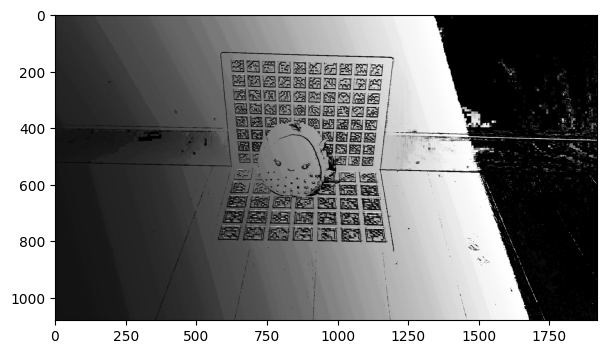

In [14]:
plt.imshow(front_edge_times, cmap="gray")
plt.savefig("front_edge_times.png")

In [89]:
img_shadow_thresh = (img_min+img_max)/2
front_edge_times = np.zeros_like(img_shadow_thresh, dtype=np.uint64)
print(front_edge_times!=0)

True
